In [1]:
#configure dataset
from os import listdir

directory_name = "./the-simpsons-characters-dataset/kaggle_simpson_testset"
image_names = listdir(directory_name)
image_names.remove('.DS_Store')
print(image_names[:5])

['abraham_grampa_simpson_0.jpg', 'abraham_grampa_simpson_1.jpg', 'abraham_grampa_simpson_10.jpg', 'abraham_grampa_simpson_11.jpg', 'abraham_grampa_simpson_12.jpg']


In [2]:
#calculate mean width and lenght
import os, random
from scipy.misc import imread, imresize

width = 0
lenght = 0
images_size = len(image_names)

for i in range(0, images_size):
    path_file = os.path.join(directory_name, image_names[i])
    image = imread(path_file)
    width += image.shape[0]
    lenght += image.shape[1]

width_mean = width//images_size
lenght_mean = lenght//images_size
dim_size = (width_mean + lenght_mean) // 2

print("Width mean: {}".format(width_mean))
print("Lenght mean: {}".format(lenght_mean))
print("Size mean dimension: {}".format(dim_size))

Width mean: 152
Lenght mean: 147
Size mean dimension: 149


In [3]:
#(149, 147), so we can redefine as (150, 150)
dim_size = 150

In [4]:
#load images
import matplotlib.pyplot as plt

#resizing and labeling
images = []
labels = []
for i in range(0, images_size):
    path_file = os.path.join(directory_name, image_names[i])
    image = imread(path_file)
    image = imresize(image, (dim_size, dim_size))
    images.append(image)
    label = image_names[i].split('_')[:-1]
    labels.append('_'.join(label))

print("Loaded {} test images".format(len(images)))

Loaded 990 test images


Label:kent_brockman, Image:443, Shape:(150, 150, 3)


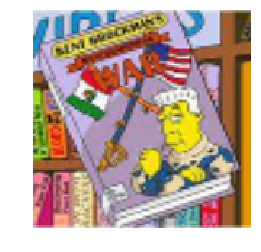

Label:abraham_grampa_simpson, Image:18, Shape:(150, 150, 3)


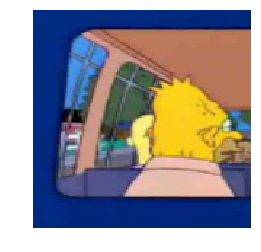

Label:kent_brockman, Image:433, Shape:(150, 150, 3)


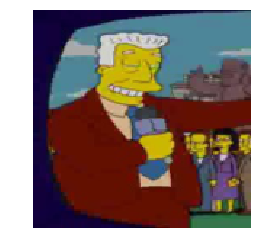

In [5]:
#show some examples
for i in range(0,3):
    idx = random.randint(0, images_size)
    image = images[idx]
    print("Label:{}, Image:{}, Shape:{}".format(labels[idx], idx, image.shape))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [6]:
#normalize data
import numpy as np

def normalize(x):
    return (x - np.amin(x))/(np.amax(x) - np.amin(x))

images_norm = []

for i in range(0, images_size):
    images_norm.append(normalize(images[i]))
    
print(images_norm[1])

[[[ 0.14814815  0.42798354  0.58847737]
  [ 0.15226337  0.43209877  0.59259259]
  [ 0.15226337  0.43209877  0.58436214]
  ..., 
  [ 0.65843621  0.68312757  0.64197531]
  [ 0.65843621  0.67901235  0.65020576]
  [ 0.65432099  0.68312757  0.65020576]]

 [[ 0.14814815  0.42798354  0.58847737]
  [ 0.14814815  0.42798354  0.58847737]
  [ 0.14814815  0.42798354  0.58024691]
  ..., 
  [ 0.65843621  0.67901235  0.65432099]
  [ 0.65432099  0.68312757  0.65432099]
  [ 0.65432099  0.68312757  0.65432099]]

 [[ 0.14814815  0.42798354  0.58847737]
  [ 0.14814815  0.42798354  0.58847737]
  [ 0.14814815  0.42798354  0.58024691]
  ..., 
  [ 0.65843621  0.67489712  0.67078189]
  [ 0.65432099  0.67901235  0.67078189]
  [ 0.65432099  0.67901235  0.66666667]]

 ..., 
 [[ 0.41152263  0.18930041  0.0781893 ]
  [ 0.41152263  0.18930041  0.07407407]
  [ 0.41152263  0.18930041  0.07407407]
  ..., 
  [ 0.41152263  0.19341564  0.06584362]
  [ 0.41152263  0.19341564  0.06995885]
  [ 0.41563786  0.19341564  0.07818

In [7]:
#one-hot encode
from sklearn import preprocessing

lb = preprocessing.LabelBinarizer()
lb = lb.fit(labels)
labels_one_hot = lb.transform(labels)

#show one-hot labels
print(lb.classes_)

#example
code = lb.transform(['marge_simpson'])
print(code)
print(lb.inverse_transform(code))


['abraham_grampa_simpson' 'apu_nahasapeemapetilon' 'bart_simpson'
 'charles_montgomery_burns' 'chief_wiggum' 'comic_book_guy'
 'edna_krabappel' 'homer_simpson' 'kent_brockman' 'krusty_the_clown'
 'lenny_leonard' 'lisa_simpson' 'marge_simpson' 'mayor_quimby'
 'milhouse_van_houten' 'moe_szyslak' 'ned_flanders' 'nelson_muntz'
 'principal_skinner' 'sideshow_bob']
[[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]]
['marge_simpson']


In [70]:
#images_norm: has the list of normalized images
#labels_one_hot: has the list of one-hot encoded labels

#build the network
import tensorflow as tf

images_norm = np.array(images_norm)
labels_one_hot = np.array(labels_one_hot)

print(images_norm.shape[1:])
print(labels_one_hot.shape[1:])

#data
X = tf.placeholder(tf.float32, (None,) + images_norm.shape[1:])
y = tf.placeholder(tf.float32, (None,) + labels_one_hot.shape[1:])

#convolution variables
input_depth = images_norm.shape[3]
output_depth = input_depth * 3
filter_shape = (2, 2, input_depth, output_depth)
filter_ = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.01))
stride_ = [1, 2, 2, 1]
pool_ = stride_
bias_ = tf.Variable(tf.zeros(output_depth))

#convolution
conv = tf.nn.conv2d(X, filter_, stride_, padding='SAME')
conv = tf.nn.bias_add(conv, bias_)
conv = tf.nn.relu(conv)
conv = tf.nn.max_pool(conv, pool_, stride_, padding='SAME')

#before classifier
flatten_shape = np.prod(conv.get_shape().as_list()[1:])
print("flatten shape: {}".format(flatten_shape))
flatten = tf.reshape(conv, [-1,flatten_shape])

#classifier variables
num_inputs = flatten.get_shape().as_list()[1]
num_outputs = labels_one_hot.shape[1:]
weights = tf.Variable(tf.truncated_normal((num_inputs,)+num_outputs, stddev=0.01))
bias = tf.Variable(tf.zeros(num_outputs))

#classifier
logits = tf.add(tf.matmul(flatten, weights), bias)


(150, 150, 3)
(20,)
flatten shape: 12996


In [71]:
#loss and optmizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

#accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [72]:
##Run the model

#remove previous weights, bias, etc
#tf.reset_default_graph()

epochs = 1
batch = 64

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs):
        output = sess.run(logits, feed_dict={X:images_norm, y:labels_one_hot})